In [1]:
# try an architecture with multiple outputs at bottlenecks (1 unit output layers) with residual connections

In [1]:
from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev2
import wispy.mscalev3
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorboard as tb
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
# https://stackoverflow.com/a/59789336/12840171
# this is the way to add custome activations - do not do
# get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
# get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})
# instead to
# otherwise problems with saving and loading
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [4]:
def compute_fft(x, y):
    """
    function to compute the fourier transform and sample frequencies.
    only keeping the positive side of the fft and normalising.
    """
    N = len(x)
    dt = x[1] - x[0]
    
    yf = 2.0/N * np.fft.fft(y)[:N//2]
    xf = np.fft.fftfreq(N, dt)[:N//2]

    return xf, yf

def plot_fft(x, y, model=None, xlim=None, logx=False, logy=False):
    xf, yf = compute_fft(x[:,0], y[:,0])
    
    plt.figure(figsize=(14, 6))
    plt.plot(xf, np.abs(yf), label='total')
    
    if model is not None:
        plt.plot(xf, np.abs(compute_fft(x[:,0], model.predict(x)[:,0]))[1], ls='--', label='model', c='k')
        
    plt.axvline(1, c='k', ls='--')
    plt.axvline(4, c='k', ls='--')
    plt.xlabel("f")
    plt.ylabel("|fft(y)|")
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim(0,10)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')

# models

In [5]:
def get_uncompiled_base_model(model_name, model_params_dict):
    assert model_name in ['resnet', 'mscalev2', 'mscalev1', 'mscalev3']

    if model_name == 'resnet':
        model = wispy.resnet.ResNet(**model_params_dict)
    elif model_name == 'mscalev2':
        model = wispy.mscalev2.build_model(**model_params_dict)
    elif model_name == 'mscalev1':
        model = pugna.models.mscalednn.build_model_2(**model_params_dict)
    elif model_name == 'mscalev3':
        model = wispy.mscalev3.build_model(**model_params_dict)

    return model


def get_compiled_base_model(model_name, model_params_dict, extra_params_dict):
    model = get_uncompiled_base_model(
        model_name=model_name, model_params_dict=model_params_dict)

    optimizer = tf.keras.optimizers.Adam(
        extra_params_dict['lr'], amsgrad=extra_params_dict['amsgrad'])

    model.compile(loss=extra_params_dict['loss'],
                  optimizer=optimizer, metrics=extra_params_dict['metrics'])

    return model

# load data

In [6]:
X_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_train.npy')[:1119]
y_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_train.npy')[:1119]

X_train_raw = np.float32(X_train_raw)
y_train_raw = np.float32(y_train_raw)

# X_train_raw = X_train_raw[:,0].reshape(-1, 1)
X_train_raw = X_train_raw[:,:2].reshape(-1, 2)

# X_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_val.npy')[:1119]
# y_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_val.npy')[:1119]

print(f"X_train_raw.shape: {X_train_raw.shape}")
print(f"y_train_raw.shape: {y_train_raw.shape}")
# print(f"X_val.shape: {X_val.shape}")
# print(f"y_val.shape: {y_val.shape}")

# lets just use 1D input - i.e., time-series
X_train = X_train_raw.copy()
y_train = y_train_raw.copy()

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")



# X_train = np.float32(X_train_raw)
# y_train = np.float32(y_train)
# X_val = np.float32(X_val)
# y_val = np.float32(y_val)

X_train_raw.shape: (1119, 2)
y_train_raw.shape: (1119, 1)
X_train.shape: (749, 2)
y_train.shape: (749, 1)
X_val.shape: (370, 2)
y_val.shape: (370, 1)


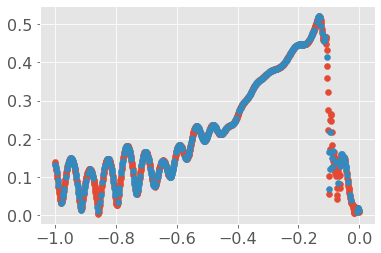

In [7]:
plt.figure()
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_val[:,0], y_val)

# create tf datasets

# base line

In [8]:
model_params_dict = dict(
    input_shape=2,
    output_shape=1,
    units=[128,128,128],
    activation='s2relu',
    n_blocks=[3,3,3],
    scales=[1,10,100],
    layers_per_block=2,
    scale_dimension=0,
    dtype=None
)

In [9]:
extra_params_dict=dict(lr=1e-4, amsgrad=False, loss='mse', metrics=None)

In [ ]:
base_model = get_compiled_base_model(model_name='mscalev3', model_params_dict=model_params_dict, extra_params_dict=extra_params_dict)

In [ ]:
%%time
base_history = base_model.fit(x=X_train, y=y_train, epochs=2001, validation_data=(X_val, y_val), verbose=0, batch_size=200)

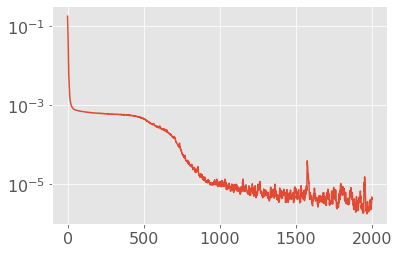

In [13]:
plt.figure()
plt.plot(base_history.history['loss'])
plt.yscale('log')

In [14]:
base_yhat = base_model.predict(X_train)

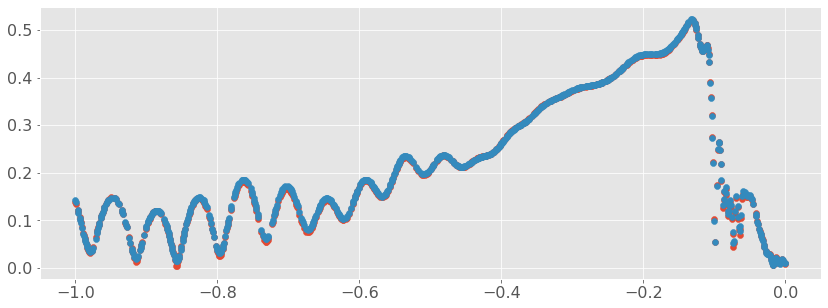

In [15]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_train[:,0], base_yhat)
# plt.xlim(-0.2, 0)

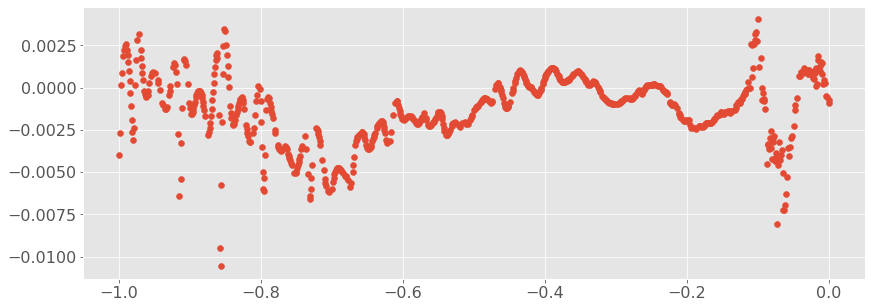

In [16]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train-base_yhat)

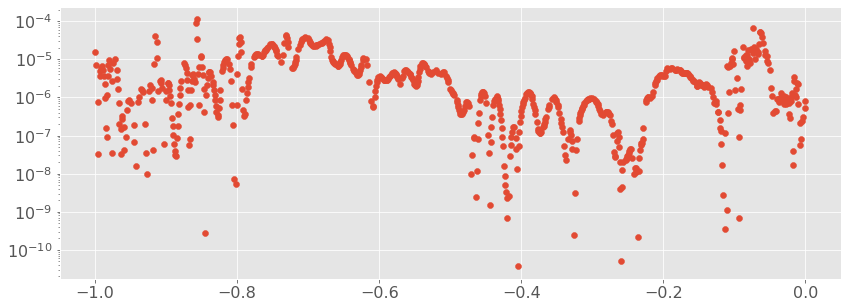

In [17]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], tf.keras.losses.mean_squared_error(y_train,base_yhat))
plt.yscale('log')

# dev

In [18]:
def get_uncompiled_model(input_shape=2, output_shape=1, units=32, activation='relu'):
    
    input_layer = tf.keras.layers.Input(shape=(input_shape,))
    
    scale_tensor = wispy.mscalev3.make_scale_tensor(input_shape, 0, 10, dtype=np.float32)
    scaled_input = wispy.mscalev3.ScaleLayer(scale_tensor)(input_layer)
    
    
    x = tf.keras.layers.Dense(units)(scaled_input)
#     x = tf.keras.layers.Dense(units)(input_layer)
#     x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Activation('s2relu')(x)
    
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    
    
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    
    
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    
    
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    
    
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    
#     x = tf.keras.layers.add([x, input_layer])
    
    output_1 = tf.keras.layers.Dense(1)(x)
    
#     x = tf.stop_gradient(x)
   
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    
#     x = tf.keras.layers.add([x, output_1])
    output_2 = tf.keras.layers.Dense(1)(x)
    
    output_3 = tf.keras.layers.add([output_1, output_2])
    
    outputs = [output_1, output_2, output_3]
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=outputs)
    return model


def get_compiled_model(input_shape=2, output_shape=1, units=32, lr=1e-3):
    model = get_uncompiled_model(input_shape=input_shape, output_shape=output_shape, units=units)

    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss='mse', optimizer=optimizer)

    return model

In [19]:
model = get_uncompiled_model(units=128, activation='relu')

In [20]:
X_train.shape

(749, 2)

In [21]:
o1, o2, o3 = model(X_train)

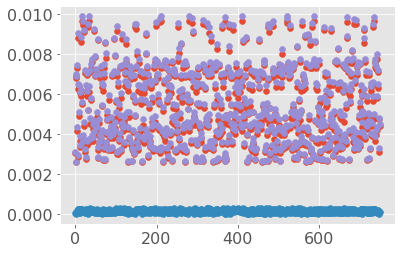

In [22]:
plt.figure()
plt.scatter(range(len(o1)), o1)
plt.scatter(range(len(o1)), o2)
plt.scatter(range(len(o1)), o3)

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
scale_layer_3 (ScaleLayer)      (None, 2)            0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 128)          384         scale_layer_3[0][0]              
__________________________________________________________________________________________________
activation (Activation)         (None, 128)          0           dense_28[0][0]                   
____________________________________________________________________________________________

In [24]:
# tf.keras.utils.plot_model(model)

In [15]:
buffer_size = 749
# batch_size = 749
batch_size = 200

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)
# train_dataset = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)
# val_dataset = val_dataset.batch(batch_size)

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [27]:
loss_fn_output_1 = tf.keras.losses.mean_squared_error
loss_fn_output_2 = tf.keras.losses.mean_squared_error
loss_fn_output_3 = tf.keras.losses.mean_squared_error

In [28]:
# Prepare the metrics.
train_loss_metric_1 = tf.keras.metrics.MeanSquaredError()
train_loss_metric_3 = tf.keras.metrics.MeanSquaredError()
# val_loss_metric = tf.keras.metrics.MeanSquaredError()

In [29]:
import time

In [30]:
# training and eval loop

In [31]:
@tf.function
def custom_train_step(x, y):
    with tf.GradientTape() as tape:
        yhat_1, yhat_2, yhat_3 = model(x, training=True)
        loss_value_1 = loss_fn_output_1(y, yhat_1)
        
        loss_value_2 = loss_fn_output_1(y-yhat_1, yhat_2)
        
        loss_value_3 = loss_fn_output_3(y, yhat_3)
    grads = tape.gradient([loss_value_1,loss_value_2,loss_value_3], model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # update training metric
    train_loss_metric_1.update_state(y, yhat_1)
    train_loss_metric_3.update_state(y, yhat_3)
    return loss_value_3

In [32]:
y_train.shape

(749, 1)

In [33]:
total_start_time = time.time()

# losses_per_iteration = tf.zeros(shape=(32, ), dtype=tf.float32)
losses_per_iteration = []
avg_losses_per_iteration = []
avg_losses_per_epoch = []

epochs = 2001
for epoch in range(epochs):
#     print(f"\nStart of epoch {epoch}")
    start_time = time.time()
    
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = custom_train_step(x_batch_train, y_batch_train)
    
    losses_per_iteration.append(loss_value)
    avg_losses_per_iteration.append(tf.reduce_mean(loss_value))
    if epoch % 200 == 0:
        print(f"epoch:{epoch}, loss:{float(train_loss_metric_3.result())}")

    avg_losses_per_epoch.append(train_loss_metric_3.result())
    # reset training metric at end of each epoch
    train_loss_metric_1.reset_states()
    train_loss_metric_3.reset_states()
    
#     print(f"Time take: {time.time() - start_time}")
print(f"Total Time taken: {time.time() - total_start_time}")

epoch:0, loss:0.06012747809290886
epoch:200, loss:0.00012242393859196454
epoch:400, loss:4.2466952436370775e-05
epoch:600, loss:2.754976048890967e-05
epoch:800, loss:1.5760597307235003e-05
epoch:1000, loss:2.2683658244204707e-05
epoch:1200, loss:7.82862935011508e-06
epoch:1400, loss:6.215493158379104e-06
epoch:1600, loss:2.0147217583144084e-05
epoch:1800, loss:1.4994176126492675e-05
epoch:2000, loss:2.8903086786158383e-05
Total Time taken: 43.09638476371765


In [34]:
# losses_per_iteration

In [35]:
len(avg_losses_per_epoch)

2001

In [36]:
# losses_per_iteration

In [37]:
plot_losses_per_iteration = [val.numpy() for val in losses_per_iteration]

In [38]:
plot_losses_per_iteration=np.concatenate((plot_losses_per_iteration), axis=-1)

In [39]:
plot_avg_losses_per_iteration = np.array([val.numpy() for val in avg_losses_per_iteration])

In [40]:
plot_avg_losses_per_epoch = np.array([val.numpy() for val in avg_losses_per_epoch])

In [41]:
plot_losses_per_iteration = plot_losses_per_iteration.reshape(-1, 1)

In [42]:
plot_avg_losses_per_epoch.shape

(2001,)

In [43]:
plot_losses_per_iteration.shape

(298149, 1)

In [44]:
plot_avg_losses_per_iteration.shape

(2001,)

In [45]:
plt.figure()
plt.plot(range(plot_avg_losses_per_epoch.shape[0]), plot_avg_losses_per_epoch)
plt.yscale('log')
# plt.xscale('log')

In [46]:
model

In [47]:
yhat_1,yhat_2,yhat = model.predict(X_train)

In [48]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], yhat_1, label='1')
plt.scatter(X_train[:,0], yhat_2, label='2')
plt.scatter(X_train[:,0], yhat, label='3', s=70)

plt.scatter(X_train[:,0], y_train, label='true')

plt.xlim(-0.2, 0)
plt.legend()

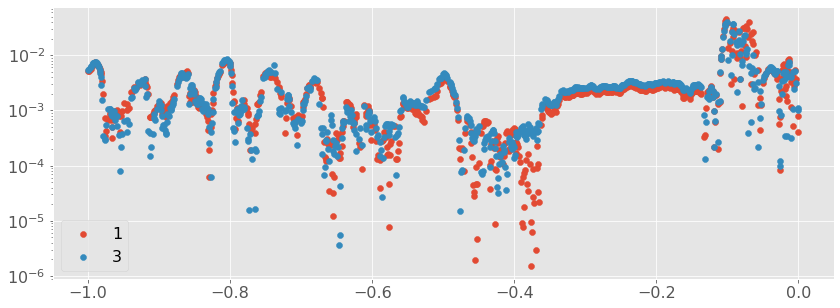

In [49]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], np.abs(y_train-yhat_1), label='1')
plt.scatter(X_train[:,0], np.abs(y_train-yhat), label='3')

# plt.xlim(-0.2, 0)
plt.yscale('log')
plt.legend()

In [50]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_train[:,0], yhat)
# plt.xlim(-0.2, 0)

In [51]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train-yhat)

# compare 

In [52]:
plt.figure()
plt.plot(base_history.history['loss'], label='base')
plt.plot(plot_avg_losses_per_epoch, label='custom')
plt.yscale('log')
# plt.xscale('log')
plt.legend()

# only backprop on final output

In [10]:
def get_uncompiled_model_2(input_shape=2, output_shape=1, units=32, scale_activation='s2relu', activation='relu', n_blocks=2, layers_per_block=2, scales=[10]):
    
    input_layer = tf.keras.layers.Input(shape=(input_shape,))

    
#     xs = [None]*len(scales)
    outputs = [None]*len(scales)
    
    for i, scale in enumerate(scales):
#         print(f"i: {i}")
        scale_tensor = wispy.mscalev3.make_scale_tensor(input_shape, 0, scale, dtype=np.float32)
        scaled_input = wispy.mscalev3.ScaleLayer(scale_tensor)(input_layer)

        x = tf.keras.layers.Dense(units)(scaled_input)
        x = tf.keras.layers.Activation(scale_activation)(x)

        outputs[i] = []

        for k in range(n_blocks):
#             print(f"\t k: {k}")
#             tmp = x
            for j in range(layers_per_block):
#                 print(f"\t\t j: {j}")
                x = tf.keras.layers.Dense(units)(x)
                x = tf.keras.layers.Activation(activation)(x)
            
#             print("\t outputs[k] appending")
#             x = tf.keras.layers.add([x, tmp])
            outputs[i].append(tf.keras.layers.Dense(1)(x))
#         print("outputs[i] appending")
        outputs[i] = tf.keras.layers.add([output for output in outputs[i]])
    
    outputs = tf.keras.layers.add([output for output in outputs])
    model = tf.keras.models.Model(inputs=input_layer, outputs=outputs)
    return model


def get_compiled_model_2(input_shape=2, output_shape=1, units=32, lr=1e-3, scale_activation='s2relu', activation='s2relu', n_blocks=2, layers_per_block=2, scales=[10]):
    model = get_uncompiled_model_2(input_shape=input_shape, output_shape=output_shape, units=units, scale_activation=scale_activation, activation=activation, n_blocks=n_blocks, layers_per_block=layers_per_block, scales=scales)

    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss='mse', optimizer=optimizer)

    return model

In [132]:
# model_2 = get_compiled_model_2(
#     units=128,
#     scale_activation='s2relu',
#     activation='relu',
#     lr=1e-3,
#     n_blocks=3,
#     layers_per_block=2,
#     scales=[1,5,10,50,100])

model_2 = get_compiled_model_2(
    units=256,
    scale_activation='s2relu',
    activation='relu',
    lr=1e-3,
    n_blocks=6,
    layers_per_block=3,
    scales=[1,10,100])

# model_2 = get_compiled_model_2(
#     units=32,
#     scale_activation='s2relu',
#     activation='relu',
#     lr=1e-3,
#     n_blocks=6,
#     layers_per_block=6,
#     scales=[1,10,100])

In [133]:
# model_2.summary()

In [134]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=100, min_lr=1e-5, cooldown=0)

# early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

# callbacks = [reduce_lr, wispy.callbacks.ThresholdCallback(1e-7)]

callbacks = [wispy.callbacks.ThresholdCallback(1e-7)]

In [135]:
# tf.keras.utils.plot_model(model_2)

In [136]:
%%time
history_2 = model_2.fit(x=X_train, y=y_train, epochs=2001,
                        validation_data=(X_val, y_val), verbose=0, batch_size=200,
                       callbacks=callbacks)

CPU times: user 16min 9s, sys: 2min 56s, total: 19min 6s
Wall time: 3min 59s


In [137]:
len(history_2.history['loss'])

1509

In [138]:
history_2.history['loss'][-1]

9.994985816774715e-08

In [139]:
plt.figure()
plt.plot(history_2.history['loss'])
plt.yscale('log')

In [140]:
plt.figure()
plt.plot(history_2.history['lr'])
plt.yscale('log')

In [141]:
yhat_model_2 = model_2.predict(X_train)

In [142]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_train[:,0], yhat_model_2)
plt.xlim(-0.2, 0)

(-0.2, 0.0)

In [143]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train-yhat_model_2)

In [144]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], tf.keras.losses.mean_squared_error(y_train,yhat_model_2))
plt.yscale('log')

# compare


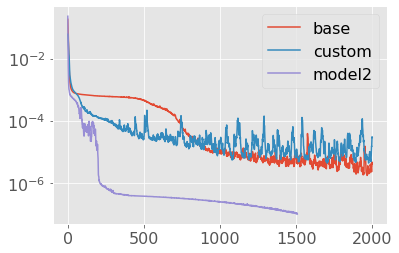

In [145]:
plt.figure()
plt.plot(base_history.history['loss'], label='base')
plt.plot(plot_avg_losses_per_epoch, label='custom')
plt.plot(history_2.history['loss'], label='model2')
plt.yscale('log')
# plt.xscale('log')
plt.legend()

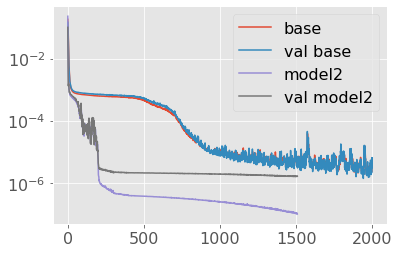

In [146]:
plt.figure()
plt.plot(base_history.history['loss'], label='base')
plt.plot(base_history.history['val_loss'], label='val base')
plt.plot(history_2.history['loss'], label='model2')
plt.plot(history_2.history['val_loss'], label='val model2')
plt.yscale('log')
# plt.xscale('log')
plt.legend()